In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import seaborn as sns
sns.set()

from utils import Manuscript
ms = Manuscript('figures')

Run this Notebook from the command line with:

    jupyter nbconvert --execute Manuscript.ipynb --to notebook --output Manuscript.ipynb
    
If it complains about `NoSuchKernel`, add your current environment to the kernelspec, e.g.:

    python -m ipykernel install --name myenv
    
Make this manuscript into pure Markdown with:

    jupyter nbconvert Manuscript.ipynb --to markdown --output Manuscript.md \
    --TagRemovePreprocessor.remove_input_tags={\"hidein\"} \
    --TagRemovePreprocessor.remove_all_outputs_tags={\"hideout\"} \
    --TagRemovePreprocessor.remove_cell_tags={\"hide\"} 

Then to convert to other formats:

    pandoc Manuscript.md -o Manuscript.pdf

or

    pandoc Manuscript.md -o Manuscript.docx

### GEOPHYSICAL TUTORIAL, June 2018

# Time-frequency decomposition

### by Matt Hall, Agile Scientific, matt@agilescientific.com

Consider a waveform or signal _s_ as a function of time _t_. For example, a sine wave with some amplitude _a_ and at some frequency _f_ might be defined by:

$$ s(t) = a \sin(2 \pi f t) $$

We can implement this mathematical function as a subroutine, usually also called a _function_, in the Python programming language. Since computers live in a discrete world, we'll need to evaluate the function over some duration and at some sample rate:

In [2]:
def sine_wave(f, a, duration, sample_rate):
    t = np.arange(0, duration, 1/sample_rate)
    return a * np.sin(2 * np.pi * f * t), t

We can now call this function, passing it a frequency _f_ = 261.63 Hz. We'll ask for 0.25 seconds, with a sample rate of 10 kHz. 

In [3]:
s, t = sine_wave(f=261.63,
                 a=1,
                 duration=0.25,
                 sample_rate=10e3)

This results in the following signal, commonly called a _time series_, which we visualize by plotting _s_ against time _t_:

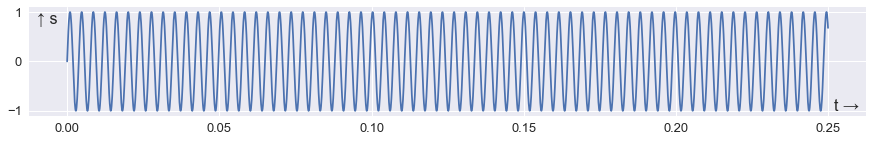

In [4]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(t, s)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.text(-0.01, 1, "↑ s", fontsize=16, va='top')
ax.text(0.252, -1, "t →", fontsize=16)
ms.savefig(fig, 'mono')
plt.show()

I've plotted the resulting array as a line, but it's really a series of discrete points represented in Python as an array of numbers, beginning with these four:

In [5]:
s[:4]

array([ 0.        ,  0.1636476 ,  0.32288289,  0.47341253])

Let's plot the first 80 points:

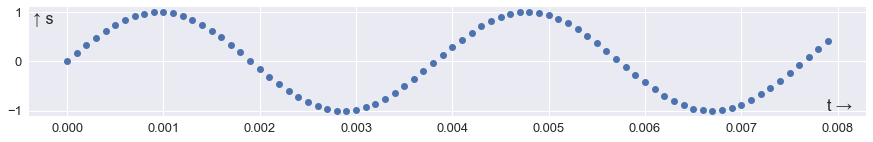

In [6]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(t[:80], s[:80], 'o')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.text(-0.00035, 1, "↑ s", fontsize=16, va='top')
ax.text(0.00815, -1, "t →", fontsize=16, ha='right')
ms.savefig(fig, 'mono100')
plt.show()

When air vibrates at this frequency, we hear a middle C, or C<sub>4</sub>. You can hear the note for yourself in the Jupyter Notebook accompanying this article at https://github.com/seg/tutorials-2018 (the notebook also contains all the code for making the plots). The code to render the array `s` as audio is very short:

In [7]:
from IPython.display import Audio
fs = 10e3
Audio(s, rate=fs)

This signal is only 0.25 seconds long and there are already a lot of wiggles. We'd love to have seismic at this frequency! Most seismic data is only played on the lower 20 to 30 keys of an 88-key piano — indeed the lowest key is A<sub>0</sub>, which at 27.5 Hz is above the peak frequency of many older surveys.

If we wanted to know the frequency of this signal, we could assume that it's a pure tone and simply count the number of cycles per unit time. But natural signals are rarely monotones, so let's make something more complicated. We can use our function to make the C-major chord with 3 notes, C<sub>4</sub>, E<sub>4</sub>, and G<sub>4</sub> by passing column vectors (by reshaping the arrays) for frequency and amplitude:

In [8]:
f = np.array([261.6, 329.6, 392.0])
a = np.array([1.5, 0.5, 1])
s, t = sine_wave(f=f.reshape(3, 1),
                 a=a.reshape(3, 1),
                 duration=0.25,
                 sample_rate=10e3)

The result is a set of three sine curves 0.25 seconds long:

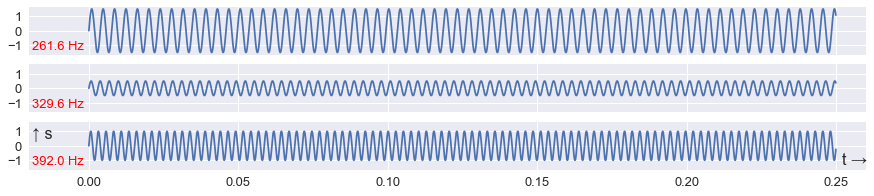

In [9]:
fig, axs = plt.subplots(figsize=(15, 3), nrows=3, sharey=True)
for ax, component, freq in zip(axs, s, f):
    ax.plot(t, component)
    ax.set_xlim(-0.02, 0.26)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.text(-0.019, -1.3, f"{freq} Hz", fontsize=13, color='red')
    fig.canvas.draw()
    labels = ax.get_xticklabels()
    ax.set_xticklabels([])
ax.set_xticklabels([l.get_text() for l in labels])
ax.text(-0.019, 1.3, "↑ s", fontsize=16, va='top')
ax.text(0.252, -1.3, "t →", fontsize=16)
ms.savefig(fig, 'three')
plt.show()

The total signal is given by the sum of the three curves:

In [10]:
s = np.sum(s, axis=0)

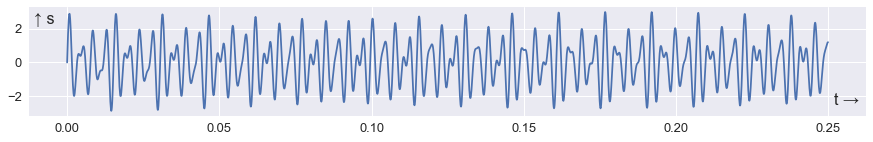

In [11]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(t, s)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.text(-0.011, 2.3, "↑ s", fontsize=16)
ax.text(0.252, -2.5, "t →", fontsize=16)
ms.savefig(fig, 'combo')
plt.show()

In [12]:
Audio(s, rate=fs)

## The Fourier transform

Although this mixed or _polytonic_ signal is just the sum of three pure tones, it is no longer a trivial matter to figure out the components. This is where the Fourier transform comes in.

We won't go into how the Fourier transform works — for what it's worth, the best explanation I've seen recently is [the introductory video](https://www.youtube.com/watch?v=spUNpyF58BY) by Grant Sanderson (3Blue1Brown on YouTube). The point is that the transform describes signals as mixtures of periodic components. Let's try it out on our chord.

First we _taper_ the signal by multiplying it by a _window_ function. Ideal pure tones have infinite duration, and the tapering helps prevent the edges of the signal from interfering with the Fourier transform. 

In [13]:
s = s * np.blackman(s.size)

The window function (green) has a tapering effect on the signal:

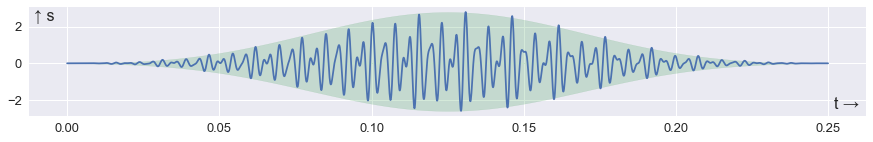

In [14]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(t, s)
ax.fill_between(t, 0, np.amax(s)*np.blackman(s.size), color='C1', alpha=0.25)
ax.fill_between(t, 0, np.amin(s)*np.blackman(s.size), color='C1', alpha=0.25)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.text(-0.011, 2.3, "↑ s", fontsize=16)
ax.text(0.252, -2.5, "t →", fontsize=16)
ms.savefig(fig, 'taper')
plt.show()

Because the function _s_ is defined for a given moment in time _t_, we call this representation of the signal the time domain.

NumPy's fast Fourier transform function `fft()` takes the signal _s_(_t_) and returns a new representation of the signal, _S_(_f_) (sometimes also called $\hat{s}(f)$. This new representation is called the frequency domain. It consists of an array of _Fourier coefficients_:

In [15]:
S = np.fft.fft(s)

A helper function, `fftfreq()`, returns the array of frequencies corresponding to the coefficients. The frequency sample interval is determined by the duration of the signal _s_: the longer the signal, the smaller the frequency sample interval. (Similarly, short sample intervals in time correspond to broad bandwidth in frequency.)

In [16]:
freq = np.fft.fftfreq(s.size, d=1/10e3)

The result is an array of _Fourier coefficients_, most of which are zero. But at and near the frequencies in the chord, the coefficients are large. The result: a 'recipe' for the chord, in terms of sinusoidal monotones.

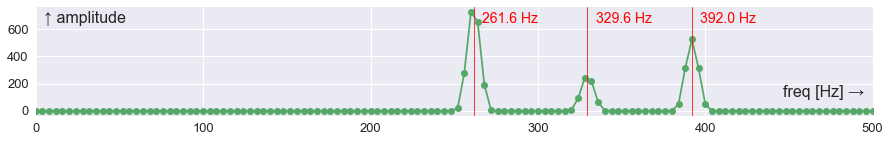

In [17]:
# We're only interested in the positive frequencies.
x, y = freq[:S.size//2], np.abs(S[:S.size//2])

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(x, y, 'o-', color='C1')
ax.set_xlim(0, 500)
for note in f:
    ax.axvline(note, c='red', lw=0.75)
    ax.text(note+5, 650, f"{note} Hz", color='red', size=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.text(5, 650, "↑ amplitude", fontsize=16)
ax.text(495, 100, "freq [Hz] →", fontsize=16, ha='right')
ms.savefig(fig, '3fft')
plt.show()

This is called the _spectrum_ of the signal _s_. It shows the magnitude of each frequency component.

### Some brief asides

#### Negative frequencies

The Fourier transform returns negative and positive frequencies:

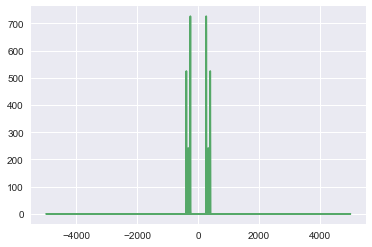

In [18]:
plt.plot(freq, abs(S), color='C1')
plt.show()

It's a bit confusing because NumPy gives you the positive frequencies first. So if you plot the result of the FFT directly you see this:

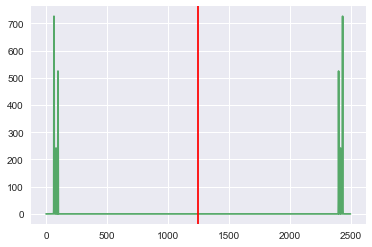

In [19]:
plt.plot(abs(S), color='C1')
plt.axvline(S.size//2, color='red')
plt.show()

The red line marks where the array switches over to negative frequencies.

In general, for real-valued signals, we are only interested in the positive frequencies. However, if we discard them completely, the inverse Fourier transform will return a signal only half as long as the original signal, and with only half the amplitude. So we keep the negative frequencies, but make temporary `x` and `y` variables for plotting:

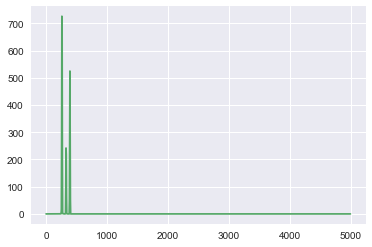

In [20]:
x, y = freq[:S.size//2], np.abs(S[:S.size//2])

plt.plot(x, y, color='C1')
plt.show()

Because the sample rate is very high, at 10,000 Hz, the spectrum goes all the way up to the Nyquist frequency of 5000 Hz. If we want to see less of it, we can either slice into it to only show, say, 200 coefficients (the samples are 4 Hz apart so this would show us 800 Hz), or we can adjust the plot:

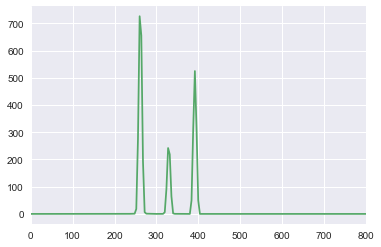

In [21]:
plt.plot(x, y, color='C1')
plt.xlim(0, 800)
plt.show()

#### Filtering in the frequency domain

The frequency domain is a very useful view of a signal. Imagine you wanted to remove the 329.6 Hz tone from the signal. It's hard to see how you could do this from the mixed time-domain signal. But in the frequency domain, the solution seems clearer: we could make those coefficients equal to zero:

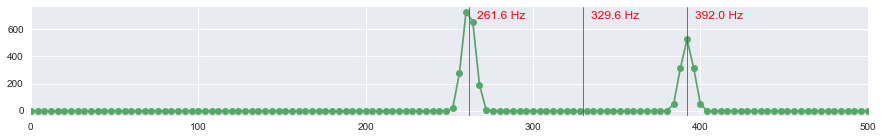

In [22]:
# Find the indices at the edge frequencies.
start, = np.where(freq==300)
end, = np.where(freq==356)

# Zero out the coefficients in that range.
# We need to remove the positive and negative sides.
S[int(start):int(end)] = 0
S[int(-end):int(-start)] = 0

x, y = freq[:freq.size//2], np.abs(S[:freq.size//2])

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(x, y, 'o-', color='C1')
ax.set_xlim(0, 500)
for note in f:
    ax.axvline(note, c='red', lw=0.75)
    ax.text(note+5, 675, f"{note} Hz", color='red')
plt.show()

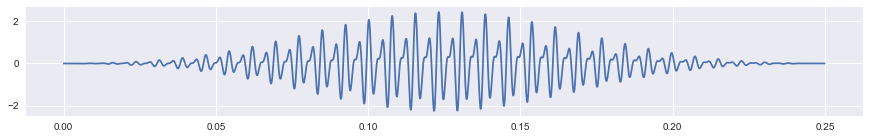

In [23]:
s_filt = np.fft.ifft(S)

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(t, s_filt.real)
plt.show()

Let's make the signal from scratch with just the two frequencies, to check that we get the same result as we got from the frequency domain filtering.

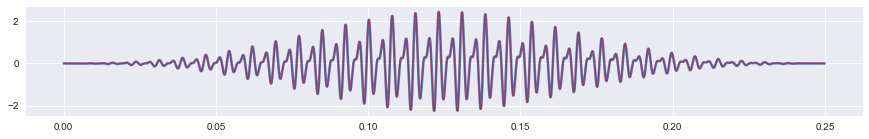

In [24]:
f = np.array([261.6, 392.0])
a = np.array([1.5, 1.0])
s, t = sine_wave(f=f.reshape(2, 1),
                 a=a.reshape(2, 1),
                 duration=0.25,
                 sample_rate=10e3)

s = np.sum(s, axis=0)

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(t, (s * np.blackman(s.size)), lw=2.5)
ax.plot(t, s_filt.real, '-', c='red', lw=0.5)
plt.show()

In [25]:
np.allclose(s * np.blackman(s.size), s_filt.real, atol=0.001)

True

The signals are the same!

#### Compression algorithms

Notice how the frequency domain representation of the signal is _sparse_ compared to the time domain representation. In other words, most of its components are very close to zero. This is why Fourier transforms, as well as other methods for casting signals to the frequency domain (e.g. the [discrete cosine transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform), which is at the heart of [JPEG compression](https://en.wikipedia.org/wiki/JPEG)), are important in data compression. By representing the data in the frequency domain, many components can be thrown away without affecting the data.

#### Welch's method

The Fourier transform yields the amplitude spectrum. Quite often we want the power spectral density, not the amplitude. This involves squaring the magnitude and dividing by the number of frequency bins... or something. Better to avoid the issue completely by just using SciPy's `welch()` function. It has the added bonus of returning the one-sided spectrum (i.e. no negative frequencies) by default. 

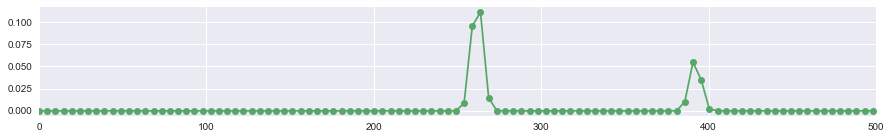

In [26]:
from scipy.signal import welch

f, Pxx = welch(s, fs=10e3, window='blackman', nperseg=2048, noverlap=0.9*2048)

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(f, Pxx, 'o-', color='C1')
ax.set_xlim(0, 500)
plt.show()

## Time-frequency representation

We now know how to unweave polytonic signals, but let's introduce another complication &mdash; signals whose components change over time. Such signals are said to be _nonstationary_. For example, think of a monotonic signal whose tone changes at some moment (see the Notebook for the code that generates this signal):

In [27]:
f0, f1 = 261.6, 392
s = np.ones_like(t)
s[:t.size//2] *= sine_wave(f0, 1.5, t.max()/2, 10e3)[0]
s[t.size//2:] *= sine_wave(f1, 1.0, t.max()/2, 10e3)[0]

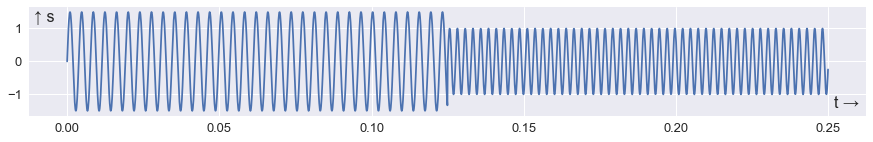

In [28]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(t, s)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.text(-0.011, 1.2, "↑ s", fontsize=16)
ax.text(0.252, -1.4, "t →", fontsize=16)
ms.savefig(fig, 'consec')
plt.show()

We can compute the Fourier transform of this signal, just as before:

In [29]:
s *= np.blackman(s.size)
S = np.fft.fft(s)
freq = np.fft.fftfreq(s.size, d=1/10e3)

And plot amplitude `S` against the frequency array `freq`:

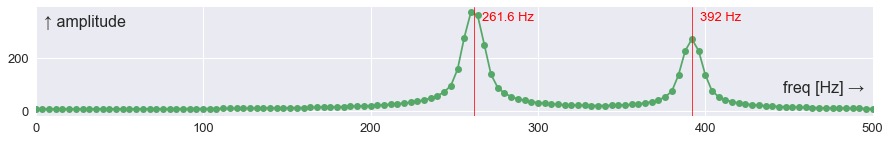

In [30]:
x, y = freq[:freq.size//2], np.abs(S[:freq.size//2])

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(x, y, 'o-', color='C1')
ax.set_xlim(0, 500)
for note in (f0, f1):
    ax.axvline(note, c='red', lw=0.75)
    ax.text(note+5, 340, f"{note} Hz", color='red', size=13)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.text(5, 320, "↑ amplitude", fontsize=16)
ax.text(495, 70, "freq [Hz] →", fontsize=16, ha='right')
ms.savefig(fig, 'consecfft')
plt.show()

It looks very similar to the spectrum we made before, but without the middle frequency. The peaks are a bit more spread out because the duration of each waveform is half what it was (the general uncertainty principle spreads signals out in frequency as they become more compact in time).

The point is that there's not much difference between the spectrum of two mixed signals, and the spectrum of two consecutive signals. If we care about the localization of signals in time (we do!), this is a problem. One solution is to turn to _time&ndash;frequency representations_. by attempting to break the signal down in time and frequency simultaneously, they offer a way to enjoy the advantages of both domains at the same time.

Python's `matplotlib` plotting library offers a convenient way of making a time&ndash;frequency plot, also known as a _spectrogram_. In a single line of code, it produces a 2D image plot showing frequency against time. 

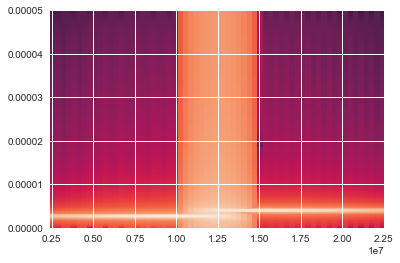

In [31]:
_ = plt.specgram(s, Fs=1/10e3, NFFT=512, noverlap=480)

With a bit more work, we can make a very rich view of our data:

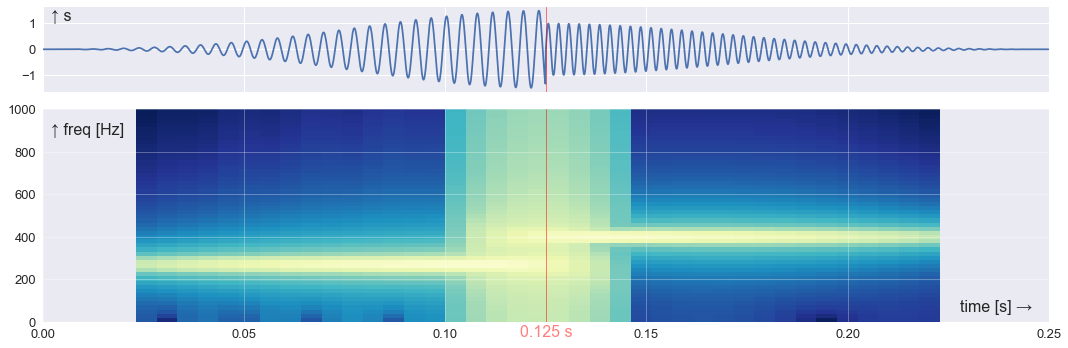

In [32]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=2, gridspec_kw={'height_ratios':[2, 5]})

axs[0].plot(t, s)
axs[0].set_xlim(0, 0.25)
axs[0].tick_params(axis='both', which='major', labelsize=13)
axs[0].set_xticklabels([])
axs[0].text(0.002, 1.1, "↑ s", fontsize=16)
axs[0].axvline(0.125, color='red', alpha=0.5, lw=1)

*_, im = axs[1].specgram(s, Fs=10e3, NFFT=512, noverlap=0.9*512, cmap='YlGnBu_r', mode='magnitude', vmax=0)
axs[1].tick_params(axis='both', which='major', labelsize=13)
# cbar = plt.colorbar(im, aspect=10)
# cbar.ax.tick_params(labelsize=12) 
axs[1].set_xlim(0, 0.25)
axs[1].set_ylim(0, 1000)
axs[1].grid(alpha=0.3)
#axs[1].grid(False)
axs[1].text(0.002, 880, "↑ freq [Hz]", fontsize=16)
axs[1].text(0.246,  50, "time [s] →", fontsize=16, ha='right')
axs[1].text(0.125,  -70, "0.125 s", fontsize=16, ha='center', color='red', alpha=0.5)
axs[1].axvline(0.125, color='red', alpha=0.5, lw=1)

plt.tight_layout()
ms.savefig(fig, 'consecspec')
plt.show()

The plot uses an algorithm called the short-time Fourier transform, or STFT. This simply makes a Fourier transform in a sliding window of length `NFFT`, with `noverlap` points overlapping on the previous window. We want `NFFT` to be long to get good frequency resolution, and we want `noverlap` to be large to get good time resolution.

Notice that we cannot quite see the exact frequency of the components &mdash; they don't last long enough to pin them down. And there's a bit of uncertainty about the timing of the transition, because to get decent frequency resolution we need a longish segment of the signal (512 samples in this case) &mdash; so we lose timing information. But overall, this plot is an improvement over the spectrum alone: we can see that there are at least 2 strong signals, with frequencies of about 250 and 400 hertz.

A piece of piano music might resemble this kind of plot. Because piano keys can only play one note, piano music looks like a series of horizontal lines:

In [33]:
s = np.loadtxt('signals/piano_22050Hz.txt')
fs = 22050

In [34]:
Audio(s, rate=fs)

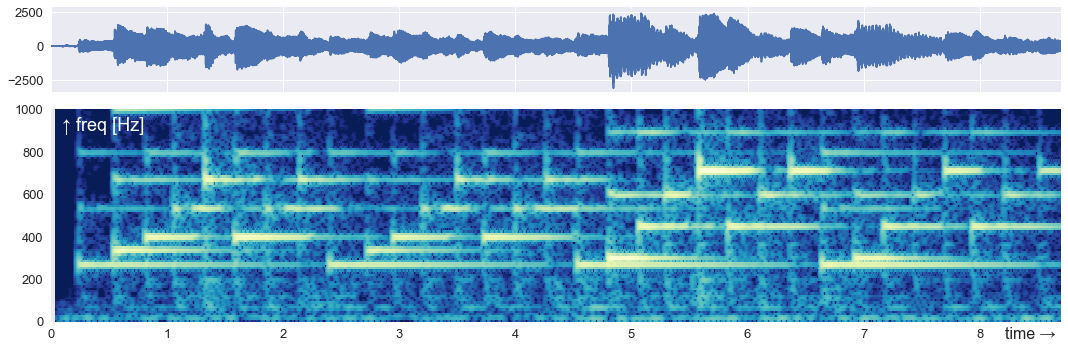

In [35]:
# Make a time basis.
t = np.linspace(0, s.size/fs, s.size)

# Make the figure.
fig, axs = plt.subplots(figsize=(15, 5), nrows=2, gridspec_kw={'height_ratios':[2, 5]})
axs[0].plot(t, s)
axs[0].set_xlim(0, 8.7)
axs[0].set_xticklabels([])
axs[0].tick_params(axis='both', which='major', labelsize=13)

_ = axs[1].specgram(s, Fs=fs, NFFT=2048, noverlap=0.9*2048, cmap='YlGnBu_r', vmin=-20 )
#plt.colorbar()
axs[1].set_ylim(0, 1000)
axs[1].set_xlim(0, 8.7)
axs[1].grid(False)
axs[1].text(8.65, -80, "time →", fontsize=16, ha='right')
axs[1].text(0.1, 900, "↑ freq [Hz]", fontsize=18, color='white')
axs[1].tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
ms.savefig(fig, 'bach')
plt.show()

There is a strong similarity between this time–frequency decomposition and the musical staff notation:

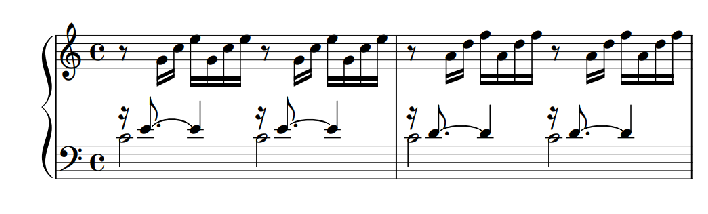

In [36]:
# This image is public domain, from
# https://commons.wikimedia.org/wiki/File:Bach-_Well-Tempered_Clavier,_Book_1_-_01_Prelude_No._1_in_C_major,_BWV_846.pdf
img = mpimg.imread('src/Bach_WTC_2bars.png')
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_axis_off()
ax.imshow(img, aspect=1)
plt.tight_layout()
ms.savefig(fig, 'staff')
plt.show()

It turns out that most interesting signals — and perhaps all natural signals — are polytonic and nonstationary. For this reason, while the timeseries is often useful, a time–frequency decomposition can be very revealing. Here are some examples; in each case, frequency is on the vertical axis and time is on the horizontal axis. The colours indicate low (blue) to high (yellow) power (proportional to the square of the amplitude).

Here's a human voice saying, "SEG". The sonorant vowel sounds have harmonics (horizontal stripes), while the sibilant sounds of the "S" and the first part of the "G" have noise-like spectral responses.

In [37]:
s = np.loadtxt('signals/seg_44100Hz.txt')
fs = 44100

Audio(s, rate=fs)

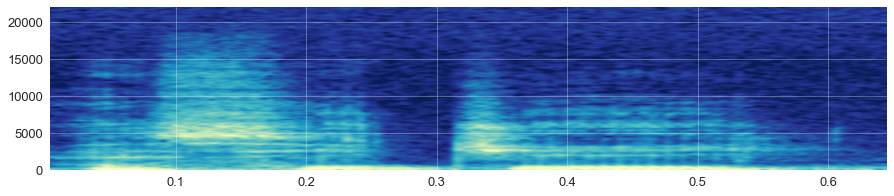

In [38]:
fig, ax = plt.subplots(figsize=(15, 3))
*_, im = ax.specgram(s, Fs=fs, NFFT=512, noverlap=333, cmap='YlGnBu_r', vmin=-40, interpolation='bicubic')
ax.tick_params(axis='both', which='major', labelsize=13)
plt.grid(alpha=0.3)
ms.savefig(fig, 'voice')
plt.show()

This spectrogram shows a 5-second series of bat chirps. I've indicated 18 kHz, the approximate limit of adult human hearing, with a red line, and if you listen to the audio of this signal in the Notebook, you can verify that the chirps are barely audible at normal playback speed; only by slowing the clip down can they be clearly heard. 

In [39]:
s = np.loadtxt('signals/bat_96000Hz.txt')
fs = 96e3

Audio(s, rate=fs/4)  # Slow it down 4x

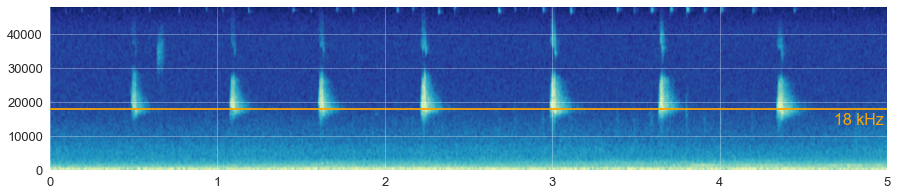

In [40]:
fig, ax = plt.subplots(figsize=(15, 3))
*_, im = ax.specgram(s, Fs=fs, cmap='YlGnBu_r', vmin=-40, interpolation='bicubic')
ax.axhline(18e3, color='orange')
ax.text(4.98, 17e3, '18 kHz', color='orange', ha='right', va='top', size=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.grid(alpha=0.3)
ms.savefig(fig, 'bat')
plt.show()

Finally, here's a volcanic 'scream' — a harmonic tremor preceeding an explosive eruption at Mt Redoubt, Alaska, in March 2009. It sounds incredible in audio, but the spectrogram is interesting too. In contrast to the bat chirp, this 15-minute-long time series has to be sped up in order to hear it.

In [41]:
s = np.loadtxt('signals/tremor_100Hz.txt')
fs = 100

Audio(s, rate=fs*40)  # Speed it up 40x. 

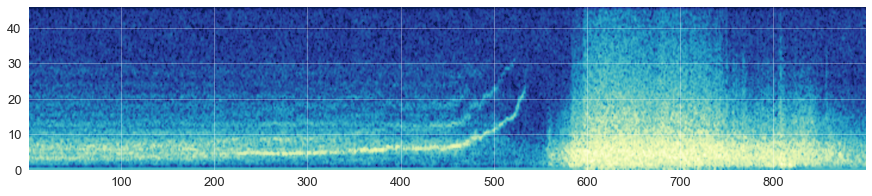

In [42]:
fig, ax = plt.subplots(figsize=(15, 3))
*_, im = ax.specgram(s, Fs=fs, cmap='YlGnBu_r', vmin=10, interpolation='bicubic')
ax.set_ylim(0, 46)
# ax.axhline(18e3, color='yellow')
# ax.text(4.98, 17e3, '18 kHz', color='yellow', ha='right', va='top', size=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.grid(alpha=0.3)
ms.savefig(fig, 'tremor')
plt.show()

## Continue exploring

All of the figures in this notebook can be reproduced by the code in the Jupyter Notebook accompanying this article at https://github.com/seg/tutorials-2018. You can even run the code on the cloud and play with it in your browser. You can't break anything — don't worry!

You'll also find more signals in the repository, synthetic and natural, from heartbeats and mysterious underwater chirps to gravitational waves and seismic traces. Not only that, there's a notebook showing you how to use another algorithm — the continuous wavelet transform — to get a different kind of time–frequency decomposition.

Happy decomposition!

## Acknowledgments

The piano recording from BWV846 by Bach is licensed CC-BY by Kimiko Ishizaka on welltemperedclavier.org. The bat chirp data is licensed CC-BY-NC by freesound.org user klankschap. Thank you to Alicia Hotovec-Ellis for her help with the Mt Redoubt data, recorded by the USGS Alaska Volcano Observatory.

----

© Matt Hall, Agile Scientific, licensed CC-BY-SA